## Quantum Optimisation for Trade Settlement in Financial Markets

Please see the document named `Methodology.pdf` for more details on the approach.

In [1]:
from typing import List, Tuple, Union, Optional
import itertools as it

import numpy as np
from docplex.mp.advmodel import Model
import networkx as nx
import matplotlib.pyplot as plt
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from plot_graph import visualise
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

SEED = 12345

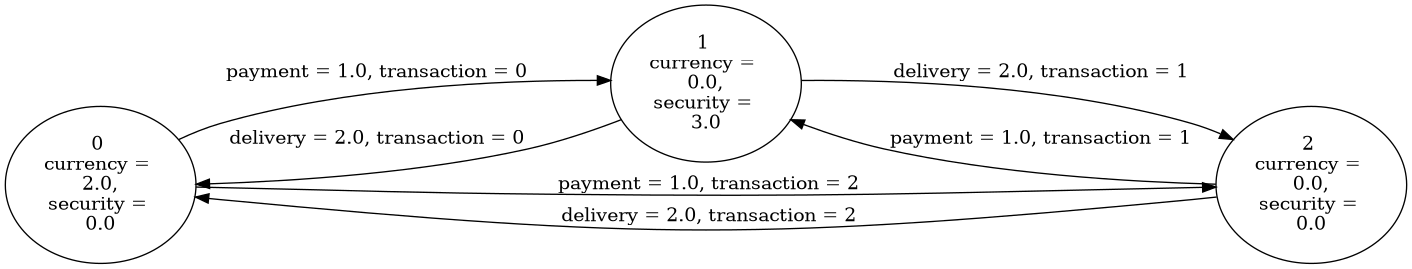

In [2]:
# Problem instance 1

num_transactions = 3
num_parties = 3
transcation_weights = np.ones(num_transactions)

G = nx.DiGraph()
G.add_nodes_from(range(num_parties))

currencies = [2., 0., 0.]
securities = [0., 3., 0.]

for k in range(num_parties):
    G.nodes[k]['currency'] = currencies[k]
    G.nodes[k]['security'] = securities[k]

delivery_elist = [
    (1, 0, 2., 0),
    (1, 2, 2., 1),
    (2, 0, 2., 2)
]

payment_elist = [
    (0, 1, 1., 0),
    (2, 1, 1., 1),
    (0, 2, 1., 2)
]

for u, v, w, t in delivery_elist:
    G.add_edge(u, v, delivery=w, transaction=t)

for u, v, w, t  in payment_elist:
    G.add_edge(u, v, payment=w, transaction=t)

G.edges(data=True)
visualise(G, hide=False);

In [3]:
# Problem Formulation

mdl = Model(name="Trade Settlement")
x = np.array([mdl.binary_var(name=f"x_{i}") for i in range(num_transactions)])
objective = mdl.sum(transcation_weights[i] * x[i] for i in range(num_transactions))
mdl.maximize(objective)

# === Helper: net effect on a party for one transaction ===
def transaction_effect(G, party, t):
    dC, dS = 0., 0.
    # payments: currency flows from u->v
    for u,v,data in G.out_edges(data=True):
        if data.get('transaction')==t and 'payment' in data:
            if u==party: dC -= data['payment']
            if v==party: dC += data['payment']
    # deliveries: securities flows from u->v
    for u,v,data in G.in_edges(data=True):
        if data.get('transaction')==t and 'delivery' in data:
            if u==party: dS -= data['delivery']
            if v==party: dS += data['delivery']
    return dC, dS


constants = []
linear_parts = []

mdl_qubo = Model(name="Trade Settlement QUBO")
x_qubo = np.array([mdl_qubo.binary_var(name=f"x_{i}") for i in range(num_transactions)])

for p in G.nodes:
    startC = G.nodes[p]['currency']
    startS = G.nodes[p]['security']

    values = np.array([transaction_effect(G,p,t) for t in range(num_transactions)])

    constraints = values.T @ x + np.array([startC, startS])
    
    mdl.add_constraint(constraints[0] >= 0)
    mdl.add_constraint(constraints[1] >= 0)
    
    linear_parts += [values.T[0], values.T[1]]
    constants += [-startC, -startS]

In [4]:
# solve exactly using CPLEX
mdl.parameters.randomseed = SEED
result = mdl.solve()

print("Objective value:", result.objective_value)
print("Values:", np.array(result.get_values(x), dtype=int))

op = from_docplex_mp(mdl)
print(op.prettyprint())

Objective value: 2.0
Values: [0 1 1]
Problem name: Trade Settlement

Maximize
  x_0 + x_1 + x_2

Subject to
  Linear constraints (6)
    -x_0 - x_2 >= -2  'c0'
    2*x_0 + 2*x_2 >= 0  'c1'
    x_0 + x_1 >= 0  'c2'
    -2*x_0 - 2*x_1 >= -3  'c3'
    -x_1 + x_2 >= 0  'c4'
    2*x_1 - 2*x_2 >= 0  'c5'

  Binary variables (3)
    x_0 x_1 x_2



In [5]:
# QAOA with subgradient descent


################### Backend and transpiler setup ###################
backend_options = {
    "precision": "single",
    "max_parallel_threads": 12,
    "max_parallel_experiments": 0,
    "max_parallel_shots": 0,
    "fusion_enable": True,
    "fusion_threshold": 14,
    "fusion_max_qubit": 4,
    "matrix_product_state_max_bond_dimension": 16,
    "matrix_product_state_truncation_threshold": 1e-8,
    "mps_sample_measure_algorithm": "mps_apply_measure",
    "mps_parallel_threshold": 12,
    "mps_omp_threads": 12,
    "mps_lapack": False,
    "seed_simulator": SEED,
}

aer_sim = AerSimulator(method="matrix_product_state", **backend_options)
aer_sim.set_max_qubits(200)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(
    backend=aer_sim, optimization_level=1, seed_transpiler=SEED
)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
 
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
 
    results = job.result()[0]
    cost = results.data.evs
 
    objective_func_vals.append(cost)
 
    return cost

# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]
 

estimator = Estimator(mode=aer_sim)
estimator._backend = aer_sim
estimator.options.default_shots = 1000

 # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=aer_sim)
sampler._backend = aer_sim
sampler.options.default_shots = 10000

######################################################################

In [8]:
np.random.seed(SEED)
lam = np.random.uniform(10, 20, size=len(constants)) # penalty coefficients
lam = 50 * np.ones(len(constants)) # # penalty coefficients

initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

print(op.prettyprint())

best_solution = None
best_obj_val = -np.inf

for step in range(20):

    print("Step:", step)
    print("Lagrange multipliers:", lam)

    # quadratic program to QUBO with Lagrangian dualization
    # minimizing hence minus sign
    qubo_obj = -mdl.sum(transcation_weights[i] * x_qubo[i] for i in range(num_transactions))

    for i, (c, l) in enumerate(zip(constants, linear_parts)):
        qubo_obj += lam[i] * (c - l @ x_qubo)

    mdl_qubo.minimize(qubo_obj)

    # Convert to QUBO
    qp2qubo = QuadraticProgramToQubo()
    qubo = qp2qubo.convert(from_docplex_mp(mdl_qubo))

    # print(qubo.prettyprint())

    qubit_op, offset = qubo.to_ising()

    circuit = QAOAAnsatz(cost_operator=qubit_op, reps=2)
    circuit.measure_all()
 
    qc = pm.run(circuit)
    qc.draw("mpl", fold=False, idle_wires=False)

    objective_func_vals = []  # Global variable

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(qc, qubit_op, estimator),
        method="COBYLA",
        tol=1e-3,
    )

    init_params = result.x + np.random.uniform(-0.1, 0.1, size=len(init_params))

    optimized_circuit = qc.assign_parameters(result.x)
    
    pub = (optimized_circuit,)
    job = sampler.run([pub], shots=int(1e4))
    counts_int = job.result()[0].data.meas.get_int_counts()
    counts_bin = job.result()[0].data.meas.get_counts()
    shots = sum(counts_int.values())
    final_distribution_int = {key: val / shots for key, val in counts_int.items()}
    print()

    keys = list(final_distribution_int.keys())
    values = list(final_distribution_int.values())
    most_likely = keys[np.argmax(np.abs(values))]
    most_likely_bitstring = to_bitstring(most_likely,qubit_op.num_qubits)
    most_likely_bitstring.reverse()
    
    print("Result bitstring:", most_likely_bitstring)

    sub = op.substitute_variables(constants=dict(zip([f"x_{i}" for i in range(num_transactions)], most_likely_bitstring)))

    print(sub.status)

    if sub.status.value == 0: # feasible
        obj_eval = op.objective.evaluate(most_likely_bitstring)

        if obj_eval > best_obj_val:
            best_obj_val = obj_eval
            best_solution = most_likely_bitstring
        

    # Update Lagrange multipliers

    alpha = 0.1
    for i, (c, l) in enumerate(zip(constants, linear_parts)):
        s = c - l @ np.array(most_likely_bitstring)
        lam[i] = max(0, lam[i] + alpha * s)  # subgradient descent update

print("Best objective value:", best_obj_val)
print("Best solution:", best_solution)

Problem name: Trade Settlement

Maximize
  x_0 + x_1 + x_2

Subject to
  Linear constraints (6)
    -x_0 - x_2 >= -2  'c0'
    2*x_0 + 2*x_2 >= 0  'c1'
    x_0 + x_1 >= 0  'c2'
    -2*x_0 - 2*x_1 >= -3  'c3'
    -x_1 + x_2 >= 0  'c4'
    2*x_1 - 2*x_2 >= 0  'c5'

  Binary variables (3)
    x_0 x_1 x_2

Step: 0
Lagrange multipliers: [50. 50. 50. 50. 50. 50.]


constraint c4 is infeasible due to substitution



Result bitstring: [0, 1, 0]
QuadraticProgramStatus.INFEASIBLE
Step: 1
Lagrange multipliers: [49.8 50.  49.9 49.9 50.1 49.8]


constraint c3 is infeasible due to substitution



Result bitstring: [1, 1, 1]
QuadraticProgramStatus.INFEASIBLE
Step: 2
Lagrange multipliers: [49.8 49.6 49.7 50.  50.1 49.8]


constraint c3 is infeasible due to substitution



Result bitstring: [1, 1, 1]
QuadraticProgramStatus.INFEASIBLE
Step: 3
Lagrange multipliers: [49.8 49.2 49.5 50.1 50.1 49.8]


constraint c5 is infeasible due to substitution



Result bitstring: [0, 0, 1]
QuadraticProgramStatus.INFEASIBLE
Step: 4
Lagrange multipliers: [49.7 49.  49.5 49.8 50.  50. ]


constraint c4 is infeasible due to substitution



Result bitstring: [0, 1, 0]
QuadraticProgramStatus.INFEASIBLE
Step: 5
Lagrange multipliers: [49.5 49.  49.4 49.7 50.1 49.8]


constraint c4 is infeasible due to substitution



Result bitstring: [0, 1, 0]
QuadraticProgramStatus.INFEASIBLE
Step: 6
Lagrange multipliers: [49.3 49.  49.3 49.6 50.2 49.6]

Result bitstring: [0, 1, 1]
QuadraticProgramStatus.VALID
Step: 7
Lagrange multipliers: [49.2 48.8 49.2 49.5 50.2 49.6]

Result bitstring: [0, 1, 1]
QuadraticProgramStatus.VALID
Step: 8
Lagrange multipliers: [49.1 48.6 49.1 49.4 50.2 49.6]

Result bitstring: [0, 1, 1]
QuadraticProgramStatus.VALID
Step: 9
Lagrange multipliers: [49.  48.4 49.  49.3 50.2 49.6]


constraint c4 is infeasible due to substitution



Result bitstring: [0, 1, 0]
QuadraticProgramStatus.INFEASIBLE
Step: 10
Lagrange multipliers: [48.8 48.4 48.9 49.2 50.3 49.4]

Result bitstring: [0, 1, 1]
QuadraticProgramStatus.VALID
Step: 11
Lagrange multipliers: [48.7 48.2 48.8 49.1 50.3 49.4]

Result bitstring: [0, 1, 1]
QuadraticProgramStatus.VALID
Step: 12
Lagrange multipliers: [48.6 48.  48.7 49.  50.3 49.4]


constraint c4 is infeasible due to substitution



Result bitstring: [0, 1, 0]
QuadraticProgramStatus.INFEASIBLE
Step: 13
Lagrange multipliers: [48.4 48.  48.6 48.9 50.4 49.2]


constraint c5 is infeasible due to substitution



Result bitstring: [0, 0, 1]
QuadraticProgramStatus.INFEASIBLE
Step: 14
Lagrange multipliers: [48.3 47.8 48.6 48.6 50.3 49.4]


constraint c4 is infeasible due to substitution



Result bitstring: [0, 1, 0]
QuadraticProgramStatus.INFEASIBLE
Step: 15
Lagrange multipliers: [48.1 47.8 48.5 48.5 50.4 49.2]


constraint c3 is infeasible due to substitution



Result bitstring: [1, 1, 1]
QuadraticProgramStatus.INFEASIBLE
Step: 16
Lagrange multipliers: [48.1 47.4 48.3 48.6 50.4 49.2]


constraint c5 is infeasible due to substitution



Result bitstring: [0, 0, 1]
QuadraticProgramStatus.INFEASIBLE
Step: 17
Lagrange multipliers: [48.  47.2 48.3 48.3 50.3 49.4]


constraint c4 is infeasible due to substitution



Result bitstring: [0, 1, 0]
QuadraticProgramStatus.INFEASIBLE
Step: 18
Lagrange multipliers: [47.8 47.2 48.2 48.2 50.4 49.2]


constraint c4 is infeasible due to substitution



Result bitstring: [0, 1, 0]
QuadraticProgramStatus.INFEASIBLE
Step: 19
Lagrange multipliers: [47.6 47.2 48.1 48.1 50.5 49. ]

Result bitstring: [0, 1, 1]
QuadraticProgramStatus.VALID
Best objective value: 2.0
Best solution: [0, 1, 1]


### Limitations

- convergence is unstable. A better idea is may be to introduce slack variables and optimize them classically instead of optimizing lambda as shown in [https://arxiv.org/pdf/1910.05788v1](Quantum Algorithms for Mixed Binary Optimization
applied to Transaction Settlement)

### Next Steps
- Based on the paper [https://arxiv.org/pdf/2307.07193](Exponential Qubit Reduction in Optimization for Financial Transaction
Settlement), we plan to implement qubit efficient mapping of qubo to VQA which can result in significant reduction in qubit count while stabilizing the convergence.